# Prescriptive Analysis
Prescriptive analysis is a type of data analysis that focuses on providing recommendations for decision-making. It goes beyond descriptive and predictive analysis by not only predicting future outcomes but also suggesting actions to achieve desired results. This type of analysis is particularly useful in optimizing processes, improving efficiency, and making informed strategic decisions.
It is a tool that helps organizations make data-driven decisions. By combining data analysis with optimization and simulation, it provides insights and recommendations.

In [16]:
# Import libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import random

In [18]:
# Read merged dataset
df = pd.read_csv("https://raw.githubusercontent.com/r41ss4/rennes_da/refs/heads/main/data/merged/merged_df.csv")
df

,airline,source_city,destination_city,departure_time,arrival_time,duration,specific_stops,add_info,price,general_stops,class
0,IndiGo,Banglore,New Delhi,Evening,Early_Morning,2.50,non-stop,No info,3897,zero,No info
1,Airline,Kolkata,Banglore,Early_Morning,Afternoon,7.25,2 stops,No info,7662,two_or_more,No info
2,Jet Airways,Delhi,Cochin,Morning,Early_Morning,19.00,2 stops,No info,13882,two_or_more,No info
3,IndiGo,Kolkata,Banglore,Evening,Evening,5.25,1 stop,No info,6218,one,No info
4,IndiGo,Banglore,New Delhi,Afternoon,Evening,4.45,1 stop,No info,13302,one,No info
...,...,...,...,...,...,...,...,...,...,...,...
311899,Vistara,Chennai,Hyderabad,Morning,Evening,10.08,1 stop,No info,69265,one,Business
311900,Vistara,Chennai,Hyderabad,Afternoon,Night,10.42,1 stop,No info,77105,one,Business
311901,Vistara,Chennai,Hyderabad,Early_Morning,Night,13.83,1 stop,No info,79099,one,Business
311902,Vistara,Chennai,Hyderabad,Early_Morning,Evening,10.00,1 stop,No info,81585,one,Business


## Optimization: Linear Programming for Resource Allocation
### Objective: Minimize the total cost of flights while meeting certain constraints

In [20]:
# Define the cost vector (price of each flight)
c_price = df['price'].values
c_price

array([ 3897,  7662, 13882, ..., 79099, 81585, 81585])

In [22]:
# Define the constraint matrix and constraint vector (e.g., total duration should be less than a certain value)
A_duration = np.array([df['duration'].values])
A_duration

array([[ 2.5 ,  7.25, 19.  , ..., 13.83, 10.  , 10.08]])

In [24]:
# Example constraint: total duration should be less than 10000 minutes
b_limit = np.array([10000])
b_limit

array([10000])

In [26]:
# Define bounds for each variable (e.g., each flight can be chosen at most once)
x_bounds = [(0, 1) for _ in range(len(c_price))]

# Solve the linear programming problem
result_op = linprog(c_price, A_ub=A_duration, b_ub=b_limit, bounds=x_bounds, method='highs')

# Display the optimization result
print("Optimization Result:")
print(result_op)

Optimization Result:
       message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
       success: True
        status: 0
           fun: 0.0
             x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           nit: 0
         lower:  residual: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
                marginals: [ 3.897e+03  7.662e+03 ...  8.158e+04  8.158e+04]
         upper:  residual: [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]
                marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
         eqlin:  residual: []
                marginals: []
       ineqlin:  residual: [ 1.000e+04]
                marginals: [-0.000e+00]


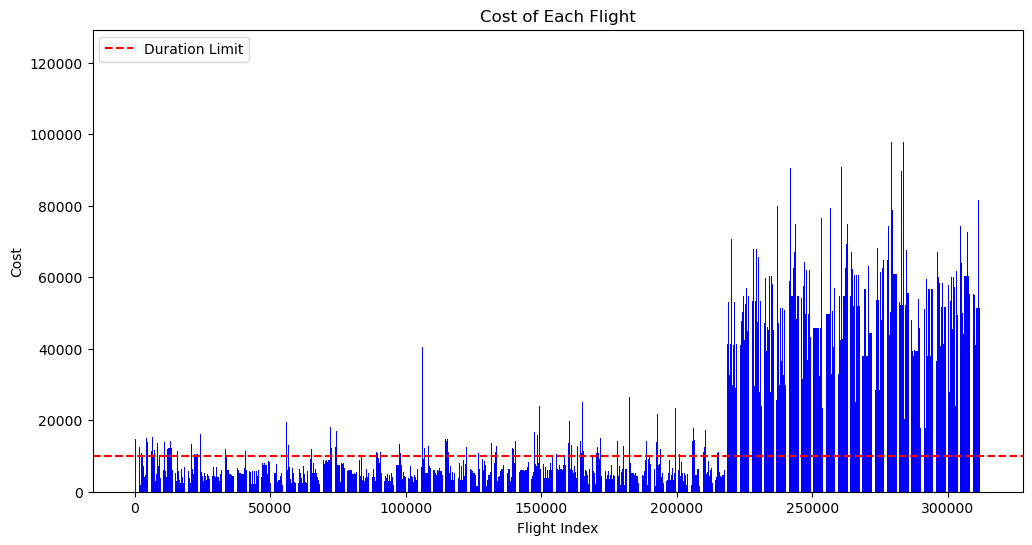

In [28]:
# Bar Plot of Cost Vector
plt.figure(figsize=(12, 6))
plt.bar(range(len(c_price)), c_price, color='blue')
plt.axhline(y=b_limit[0], color='red', linestyle='--', label='Duration Limit')
plt.xlabel('Flight Index')
plt.ylabel('Cost')
plt.title('Cost of Each Flight')
plt.legend()
plt.show()

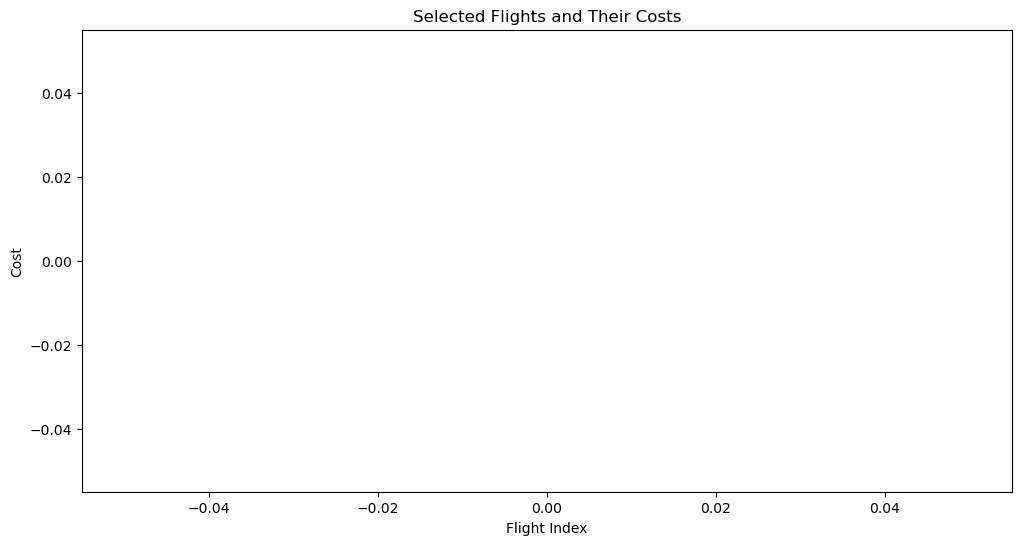

In [30]:
# Bar Plot of Selected Flights and Their Costs
# Reset df and create selected_flights variable
df_reset = df.reset_index(drop=True)
selected_flights = df_reset.iloc[result_op.x.round().astype(bool)]
selected_flights = selected_flights[['airline', 'duration', 'price']]

# Make the visual representation
plt.figure(figsize=(12, 6))
plt.bar(selected_flights.index, selected_flights['price'], color='green')
plt.xlabel('Flight Index')
plt.ylabel('Cost')
plt.title('Selected Flights and Their Costs')
plt.show()

In [32]:
# Review problem with no flights selected
if not selected_flights.empty:
    plt.figure(figsize=(12, 6))
    plt.bar(selected_flights.index, selected_flights['price'], color='green')
    plt.xlabel('Flight Index')
    plt.ylabel('Cost')
    plt.title('Selected Flights and Their Costs')
    plt.show()
else:
    print("No flights were selected by the optimization process.")

No flights were selected by the optimization process.


#### Modify selection to ensure selection of some within the sample
As the 'selected_flights' in the original criteria did not provided any flights that could fit in, it is possible to try another criteria to select flights...

In [35]:
# Add a minimum selection constraint (e.g., at least 5 flights should be selected)
A_min_selection = np.ones((1, len(c_price)))
b_min_selection = np.array([5])

In [37]:
# Example constraint: total duration should be less than 20000 minutes
b_limitd = np.array([20000])
b_limitd

array([20000])

In [39]:
# Combine the constraints
A_combined = np.vstack([A_duration, A_min_selection])
b_combined = np.hstack([b_limitd, b_min_selection])

In [41]:
# Solve the linear programming problem with the combined constraints
result_opnm = linprog(c_price, A_ub=A_combined, b_ub=b_combined, bounds=x_bounds, method='highs')

In [43]:
result_opnm

       message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
       success: True
        status: 0
           fun: 0.0
             x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           nit: 0
         lower:  residual: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
                marginals: [ 3.897e+03  7.662e+03 ...  8.158e+04  8.158e+04]
         upper:  residual: [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]
                marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
         eqlin:  residual: []
                marginals: []
       ineqlin:  residual: [ 2.000e+04  5.000e+00]
                marginals: [-0.000e+00 -0.000e+00]

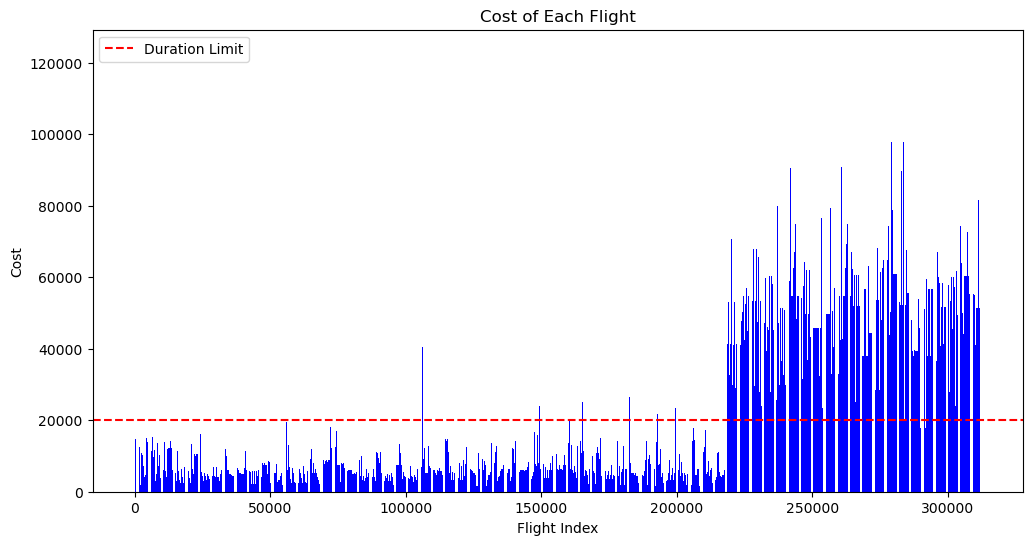

In [45]:
# Check if the optimization was successful
# Bar Plot of Cost Vector
if result_opnm.success:
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(c_price)), c_price, color='blue')
    plt.axhline(y=b_limitd[0], color='red', linestyle='--', label='Duration Limit')
    plt.xlabel('Flight Index')
    plt.ylabel('Cost')
    plt.title('Cost of Each Flight')
    plt.legend()
    plt.show()
else:
    print("No flights were selected by the optimization process.")

In [47]:
# Reset df and create selected_flights variable
df_reset = df.reset_index(drop=True)
selected_flightsnb = df_reset.iloc[result_opnm.x.round().astype(bool)]
selected_flightsnb = selected_flightsnb[['airline', 'duration', 'price']]

In [49]:
# Review problem with no flights selected
if not selected_flightsnb.empty:
    plt.figure(figsize=(12, 6))
    plt.bar(selected_flightsnb.index, selected_flightsnb['price'], color='green')
    plt.xlabel('Flight Index')
    plt.ylabel('Cost')
    plt.title('Selected Flights and Their Costs')
    plt.show()
else:
    print("No flights were selected by the optimization process.")

No flights were selected by the optimization process.


### Decision Analysis
#### Decision Tree for Flight Class Prediction
In this section the objective is to predict the class of a flight based on other features

In [51]:
# Prepare the data for decision tree
X = df[['duration', 'price']]
y = df['class']

In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
# Create and train the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [57]:
# Predict the class of flights in the test set
y_pred = clf.predict(X_test)

In [59]:
# Evaluate the decision tree model
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Decision Tree Accuracy: 0.9897512076262129
Classification Report:
              precision    recall  f1-score   support

    Business       1.00      1.00      1.00     27843
     Economy       0.99      0.99      0.99     62213
     No info       0.87      0.86      0.87      3516

    accuracy                           0.99     93572
   macro avg       0.95      0.95      0.95     93572
weighted avg       0.99      0.99      0.99     93572



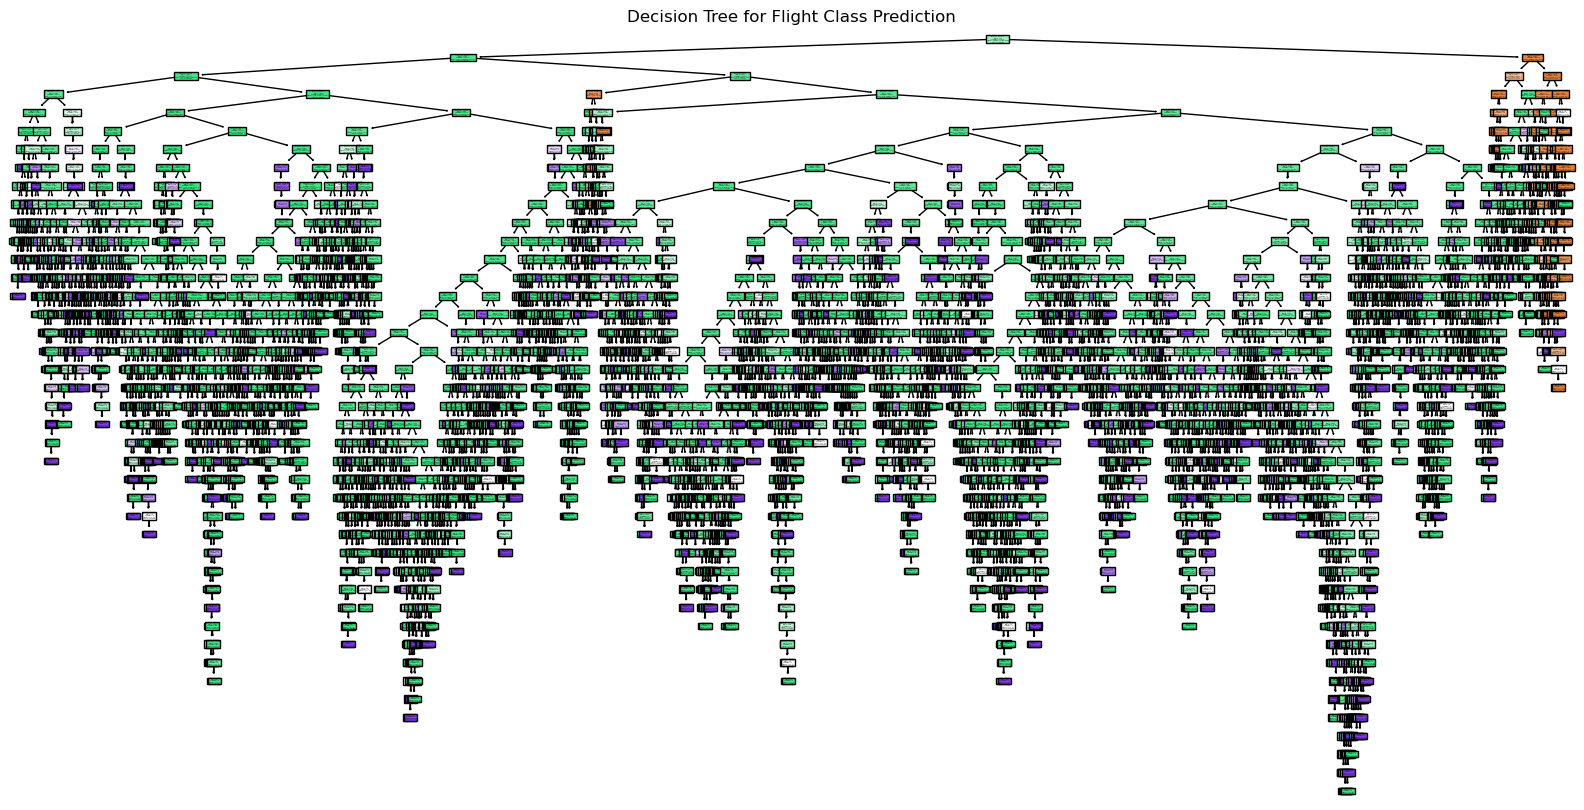

In [61]:
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=['duration', 'price'], class_names=clf.classes_, filled=True)
plt.title("Decision Tree for Flight Class Prediction")
plt.show()

#### Simplification of the decision tree
As the visual representation of the decision tree is too complex, a simpler way could be done

In [63]:
# Create bins for duration and price
df['duration_bin'] = pd.cut(df['duration'], bins=5, labels=False)
df['price_bin'] = pd.cut(df['price'], bins=5, labels=False)

In [65]:
# Prepare the data for decision tree
X_bin = df[['duration_bin', 'price_bin']]
y_bin = df['class']

In [67]:
# Split the data into training and testing sets
X_trainb, X_testb, y_trainb, y_testb = train_test_split(X_bin, y_bin, test_size=0.3, random_state=42)

In [69]:
# Create and train the decision tree classifier with a maximum depth to simplify it
clfb = DecisionTreeClassifier(random_state=42, max_depth=3)
clfb.fit(X_trainb, y_trainb)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [71]:
# Predict the class of flights in the test set
y_predb = clfb.predict(X_testb)

In [73]:
# Evaluate the decision tree model
accuracy = accuracy_score(y_testb, y_predb)
print(f"Decision Tree Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_testb, y_predb))

Decision Tree Accuracy: 0.9491835164365409
Classification Report:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Business       1.00      0.96      0.98     27843
     Economy       0.93      1.00      0.96     62213
     No info       0.00      0.00      0.00      3516

    accuracy                           0.95     93572
   macro avg       0.64      0.65      0.65     93572
weighted avg       0.91      0.95      0.93     93572



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


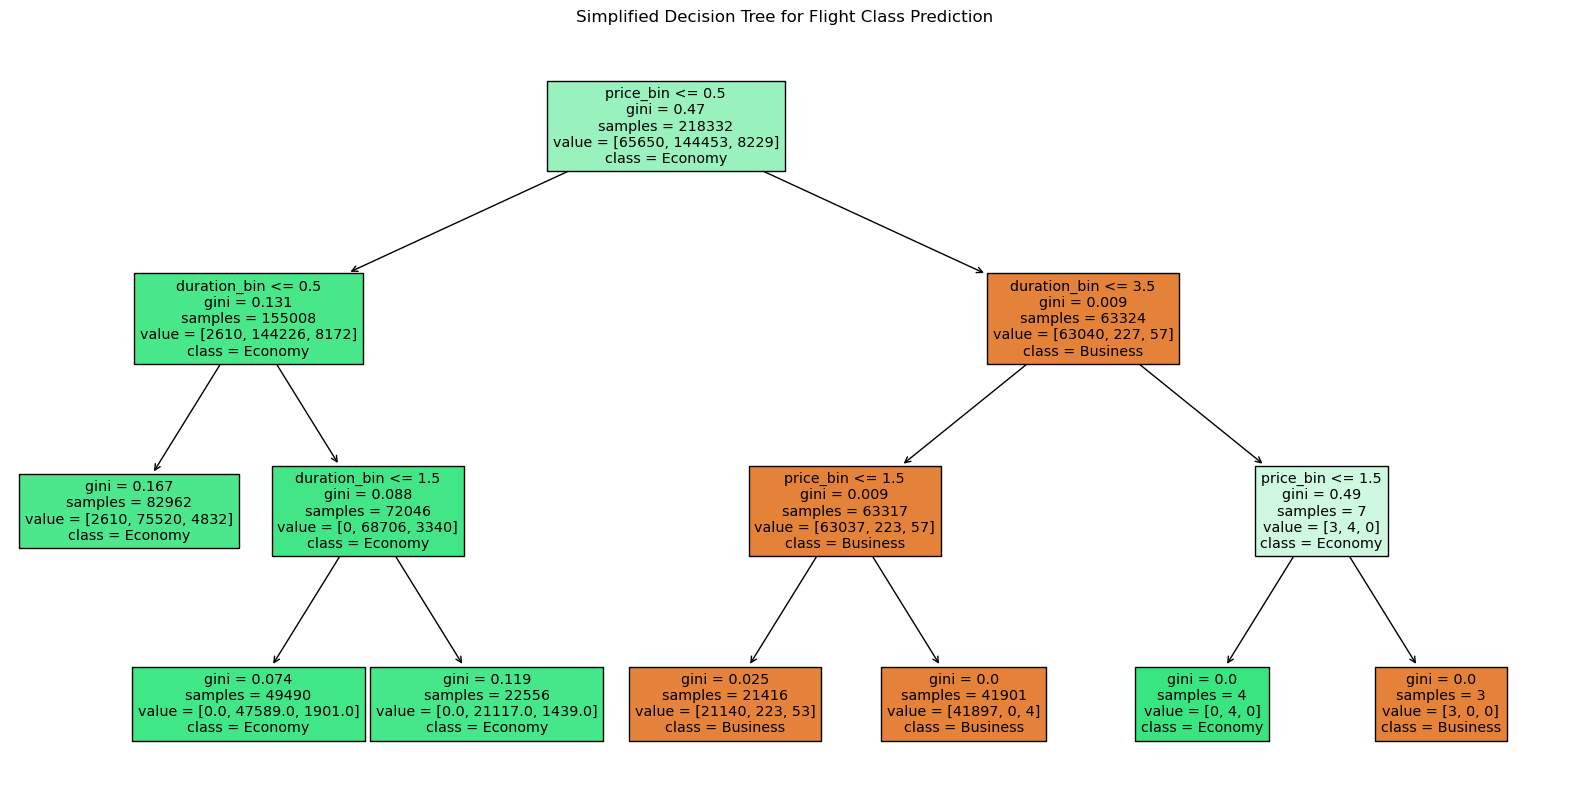

In [75]:
# Plot the simplified decision tree
plt.figure(figsize=(20, 10))
plot_tree(clfb, feature_names=['duration_bin', 'price_bin'], class_names = clfb.classes_, filled = True)
plt.title("Simplified Decision Tree for Flight Class Prediction")
plt.show()

In [77]:
# Plot the simplified decision tree with label related to long-short and cheap or expensive
# Create bins for duration and price with labels
duration_labels = ['Very Short', 'Short', 'Medium', 'Long', 'Very Long']
price_labels = ['Very Cheap', 'Cheap', 'Moderate', 'Expensive', 'Very Expensive']
df['duration_bin_l'] = pd.cut(df['duration'], bins=5, labels=duration_labels)
df['price_bin_l'] = pd.cut(df['price'], bins=5, labels=price_labels)

In [79]:
# Prepare the data for decision tree in a more humanlike way
X_bin_l = pd.get_dummies(df[['duration_bin_l', 'price_bin_l']])
y_bin_l = df['class']

In [81]:
# Split the data into training and testing sets
X_trainbl, X_testbl, y_trainbl, y_testbl = train_test_split(X_bin_l, y_bin_l, test_size=0.3, random_state=42)

In [83]:
# Create and train the decision tree classifier with a maximum depth to simplify it
clfbl = DecisionTreeClassifier(random_state=42, max_depth=3)
clfbl.fit(X_trainbl, y_trainbl)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [85]:
# Predict the class of flights in the test set
y_predbl = clfbl.predict(X_testbl)

In [87]:
# Evaluate the decision tree model
accuracy = accuracy_score(y_testbl, y_predbl)
print(f"Decision Tree Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_testbl, y_predbl))

Decision Tree Accuracy: 0.9491835164365409
Classification Report:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Business       1.00      0.96      0.98     27843
     Economy       0.93      1.00      0.96     62213
     No info       0.00      0.00      0.00      3516

    accuracy                           0.95     93572
   macro avg       0.64      0.65      0.65     93572
weighted avg       0.91      0.95      0.93     93572



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


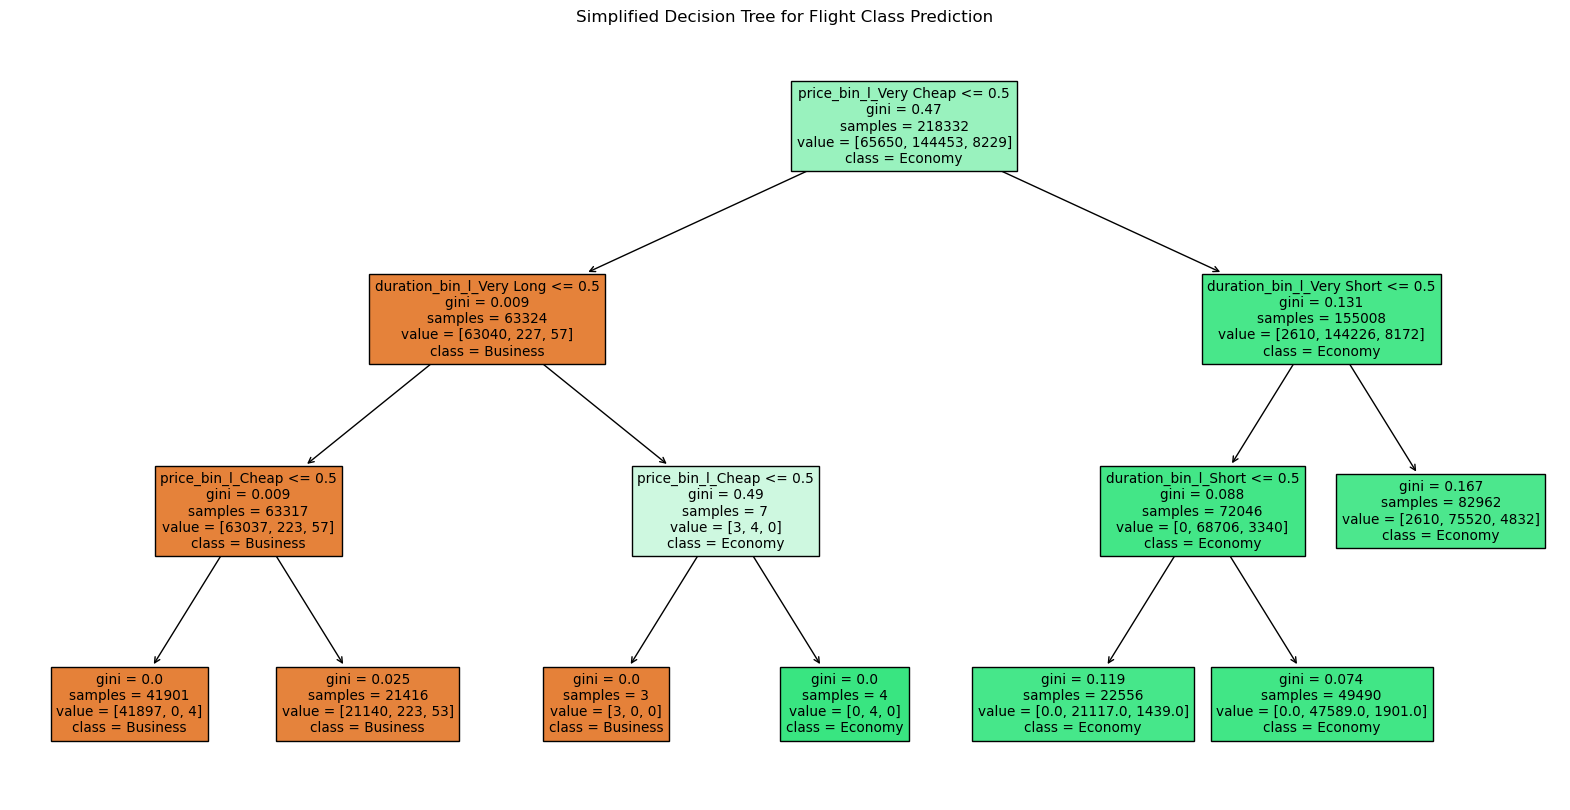

In [89]:
# Plot the simplified decision tree with labels
plt.figure(figsize=(20, 10))
plot_tree(clfbl, feature_names=X_bin_l.columns, class_names=clfbl.classes_, filled=True)
plt.title("Simplified Decision Tree for Flight Class Prediction")
plt.show()

#### Decision Tree for Predicting Flight Duration Range

In [91]:
# Prepare the data for decision tree
X_pa = df[['price', 'airline']]
X_pa = pd.get_dummies(X_pa)
y_d = df['duration_bin_l']

In [93]:
# Split the data into training and testing sets
X_trainpa, X_testpa, y_trainpa, y_testpa = train_test_split(X_pa, y_d, test_size=0.3, random_state=42)

In [95]:
# Create and train the decision tree classifier with a maximum depth to simplify it
clfpa = DecisionTreeClassifier(random_state=42, max_depth=3)
clfpa.fit(X_trainpa, y_trainpa)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [97]:
# Predict the duration range of flights in the test set
y_predpa = clfpa.predict(X_testpa)

In [99]:
# Evaluate the decision tree model
accuracy = accuracy_score(y_testpa, y_predpa)
print(f"Decision Tree Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Decision Tree Accuracy: 0.5517889967084171
Classification Report:
              precision    recall  f1-score   support

    Business       1.00      1.00      1.00     27843
     Economy       0.99      0.99      0.99     62213
     No info       0.87      0.86      0.87      3516

    accuracy                           0.99     93572
   macro avg       0.95      0.95      0.95     93572
weighted avg       0.99      0.99      0.99     93572



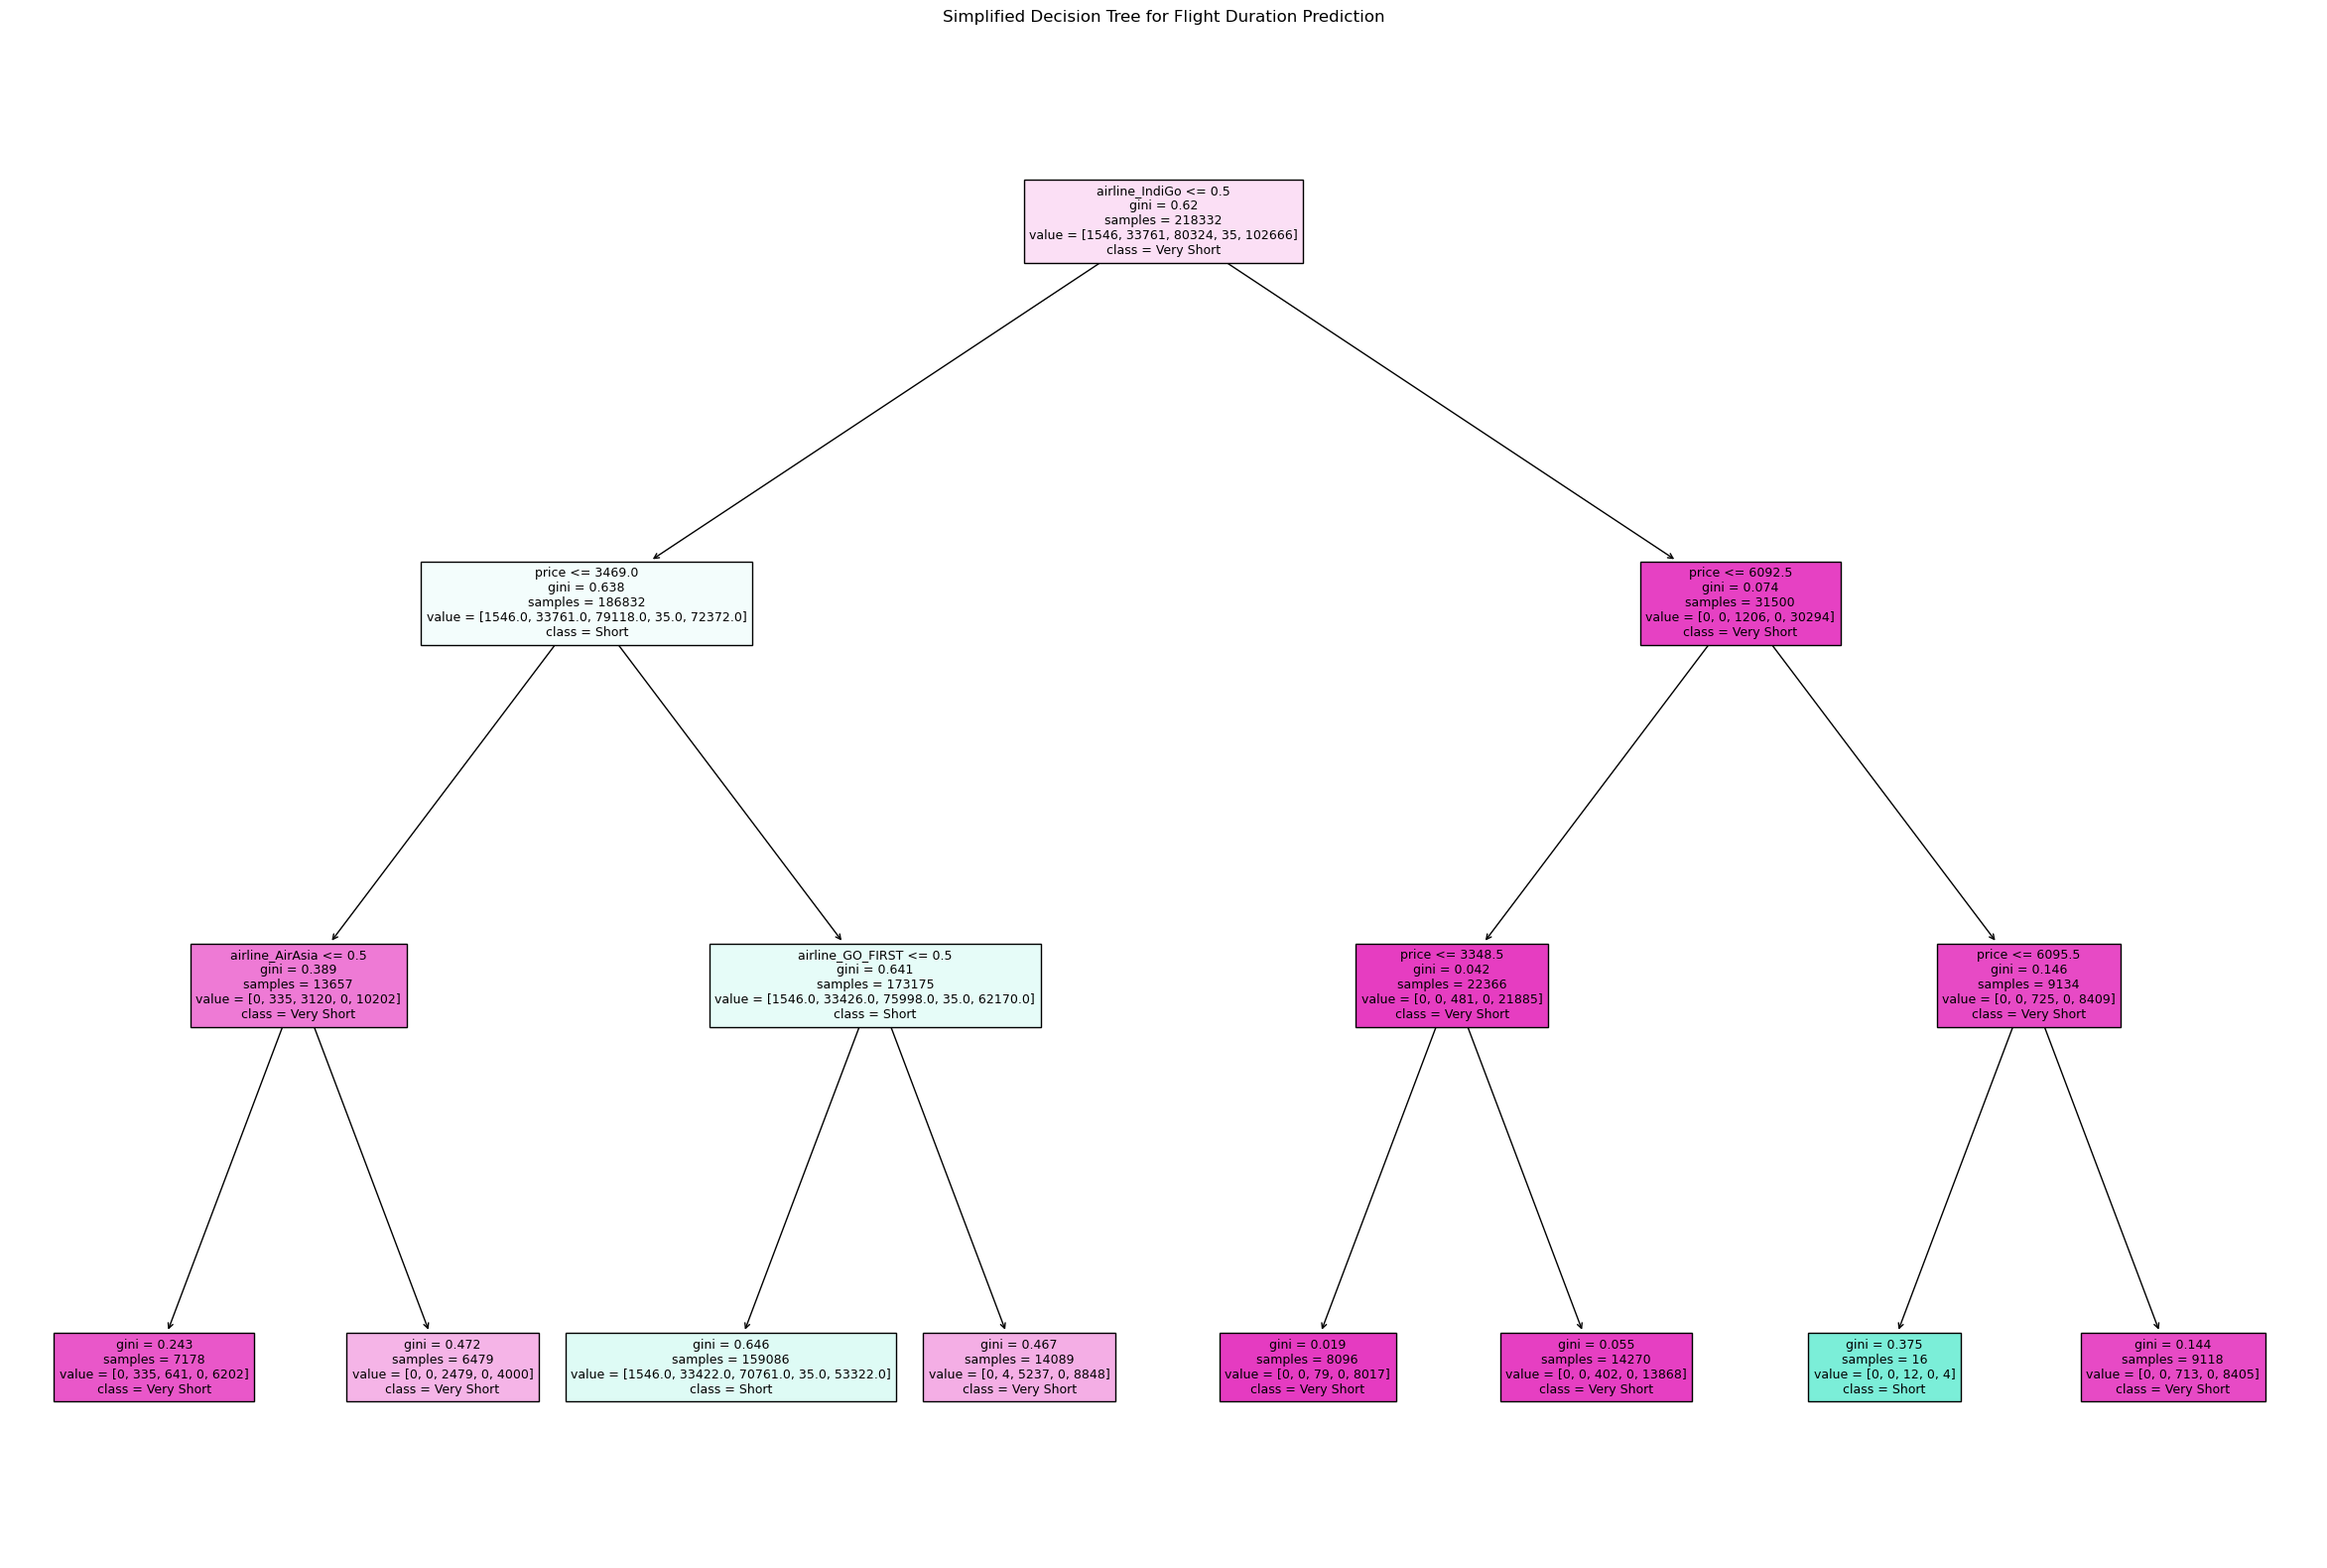

In [101]:
# Plot the simplified decision tree with human-friendly labels
# plt.figure(figsize=(30, 10))  
plt.figure(figsize=(30, 20))  
plot_tree(clfpa, feature_names=X_pa.columns, class_names=clfpa.classes_, filled=True, fontsize=9) 
plt.title("Simplified Decision Tree for Flight Duration Prediction")
plt.show()

#### Scenario Analysis for Different Flight Classes

In [103]:
# Scenario 1: Predicting flight price range for a new flight with specific duration and airline
nf1 = pd.DataFrame({'duration': [300], 'airline': ['IndiGo']})
nf1_encoded = pd.get_dummies(nf1).reindex(columns=X_pa.columns, fill_value=0)
predicted_price_range = clfpa.predict(nf1_encoded)
print(f"Predicted price range for new flight (300 minutes duration, IndiGo): {predicted_price_range[0]}")

Predicted price range for new flight (300 minutes duration, IndiGo): Very Short


In [105]:
# Scenario 2: Predicting flight duration range for another new flight with different price and airline
nf2 = pd.DataFrame({'price': [5000], 'airline': ['Air India']})
nf2_encoded = pd.get_dummies(nf2).reindex(columns=X_pa.columns, fill_value=0)
predicted_duration_range = clfpa.predict(nf2_encoded)
print(f"Predicted duration range for new flight (5000 price, Air India): {predicted_duration_range[0]}")

Predicted duration range for new flight (5000 price, Air India): Short


### Simulation
#### Monte Carlo Simulation for Price Prediction
The objective of this section is to simulate different scenarios to predict flight prices

In [107]:
# Define a function to simulate flight prices based on random variations in duration and other factors
def simulate_price(duration):
    base_price = 100  # Base price for simulation
    price_variation = random.uniform(-0.2, 0.2) * base_price  # Random variation in price
    simulated_price = base_price + (duration * 0.1) + price_variation  # Simulated price formula
    return simulated_price

In [109]:
# Perform Monte Carlo simulation for a sample of flights
num_simulations = 100000
simulated_prices = [simulate_price(duration) for duration in df['duration'].sample(num_simulations)]

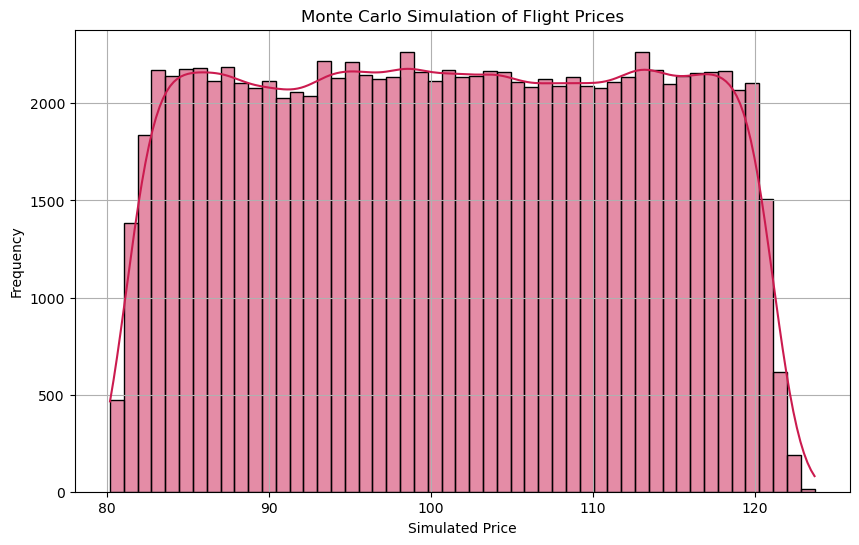

In [111]:
# Plot the distribution of simulated prices
plt.figure(figsize=(10, 6))
# Use the same colormap for different colors
color = sns.color_palette('rocket', as_cmap=True)(0.5)

sns.histplot(simulated_prices, kde=True, color=color)
plt.title("Monte Carlo Simulation of Flight Prices")
plt.xlabel("Simulated Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#### Discrete Event Simulation (DES)
DES models the operation of a system as a sequence of discrete events in time. Simulate the completion times of flights using Discrete Event Simulation (DES).   

The objective is to model and analyze the sequence of flight events over time to understand the impact of flight durations on the overall system performance.

In [ ]:
# Install simpy for analysis
!pip install simpy

In [114]:
# Import simpy
import simpy

In [116]:
# Define a simple process
#def flight_process(env, name, duration):
#    yield env.timeout(duration)
#    print(f'Flight {name} completed at {env.now}')
# Define a simple process and collect start and end times
def flight_process(env, name, duration, start_times, end_times):
    start_times[name] = env.now
    yield env.timeout(duration)
    end_times[name] = env.now

In [118]:
# Set up the environment
env = simpy.Environment()

In [120]:
# Dictionaries to store start and end times
start_times = {}
end_times = {}

In [122]:
# Add processes to the environment
#for i, row in df.iterrows():
#    env.process(flight_process(env, f'Flight {i}', row['duration']))
# Add processes to the environment
for i, row in df.iterrows():
    env.process(flight_process(env, f'Flight {i}', row['duration'], start_times, end_times))

In [124]:
# Run the simulation
des_r = env.run(until=100000)

In [126]:
# Create a DataFrame for visualization
gantt_data = pd.DataFrame({
    'Flight': list(start_times.keys()),
    'Start': list(start_times.values()),
    'End': list(end_times.values())
})

In [128]:
# Ensure there are no zero durations
gantt_data = gantt_data[gantt_data['End'] > gantt_data['Start']]

In [130]:
gantt_data

,Flight,Start,End
0,Flight 0,0,0.83
1,Flight 1,0,0.83
2,Flight 2,0,0.83
3,Flight 3,0,0.83
4,Flight 4,0,0.83
...,...,...,...
311899,Flight 311899,0,47.40
311900,Flight 311900,0,47.75
311901,Flight 311901,0,47.75
311902,Flight 311902,0,49.83


In [132]:
# Group the data by duration intervals of 5
gantt_data['Duration'] = gantt_data['End'] - gantt_data['Start']
gantt_data['Duration Group'] = pd.cut(gantt_data['Duration'], bins=range(0, 55, 5), right=False)

In [134]:
gantt_data

,Flight,Start,End,Duration,Duration Group
0,Flight 0,0,0.83,0.83,"[0, 5)"
1,Flight 1,0,0.83,0.83,"[0, 5)"
2,Flight 2,0,0.83,0.83,"[0, 5)"
3,Flight 3,0,0.83,0.83,"[0, 5)"
4,Flight 4,0,0.83,0.83,"[0, 5)"
...,...,...,...,...,...
311899,Flight 311899,0,47.40,47.40,"[45, 50)"
311900,Flight 311900,0,47.75,47.75,"[45, 50)"
311901,Flight 311901,0,47.75,47.75,"[45, 50)"
311902,Flight 311902,0,49.83,49.83,"[45, 50)"


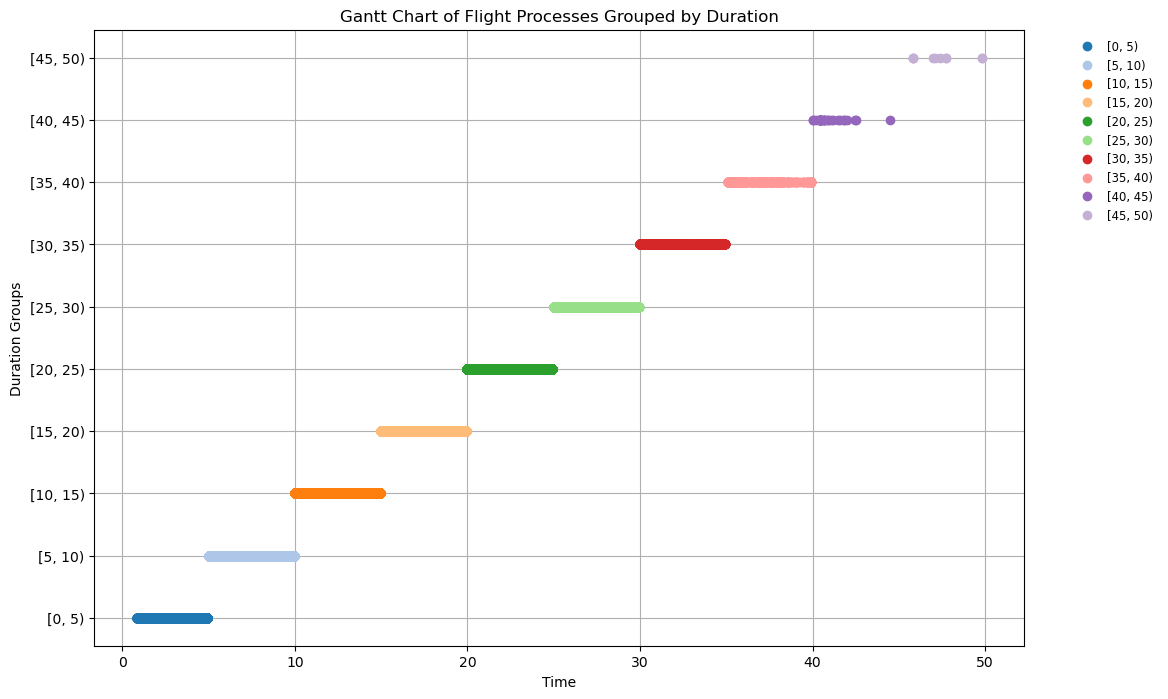

In [136]:
# Plot the Gantt chart with grouped durations
plt.figure(figsize=(12, 8))
# Use the same colormap for different colors
colors = plt.cm.tab20.colors  
for i, (name, group) in enumerate(gantt_data.groupby('Duration Group', observed=True)):
    plt.plot(group['End'], [i] * len(group), marker='o', linestyle='', color=colors[i % len(colors)], label=f'{name}')

# Customize graphic
plt.yticks(range(len(gantt_data.groupby('Duration Group', observed=True))), [f'{name}' for name, _ in gantt_data.groupby('Duration Group', observed=True)])
plt.xlabel('Time')
plt.ylabel('Duration Groups')
plt.title('Gantt Chart of Flight Processes Grouped by Duration')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, fontsize='small', frameon=False)
plt.grid(True)
plt.show()

In [138]:
# Count the number of flights in each duration group
flight_counts = gantt_data['Duration Group'].value_counts().sort_index()

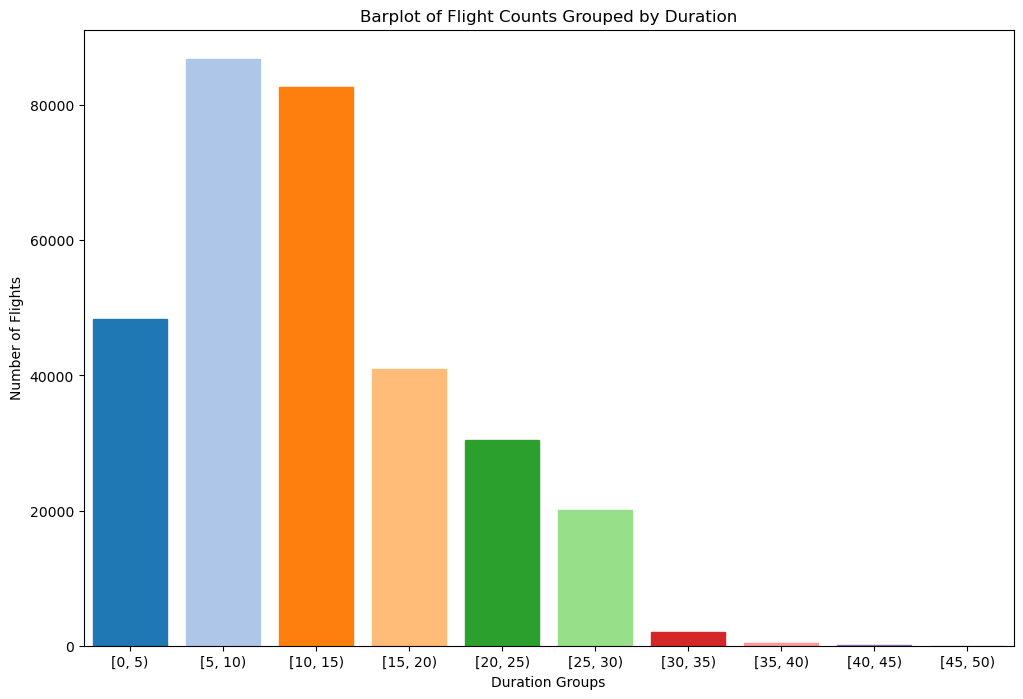

In [140]:
# Plot the barplot of flight counts grouped by duration groups with same colors as Gantt chart
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x=flight_counts.index, y=flight_counts.values)

# Set colors for each bar based on the Gantt chart colors
for i, bar in enumerate(barplot.patches):
    bar.set_color(colors[i % len(colors)])

# Customize the barplot
plt.title('Barplot of Flight Counts Grouped by Duration')
plt.xlabel('Duration Groups')
plt.ylabel('Number of Flights')
plt.show()

#### System Dynamics (SD)
This method uses stocks, flows, internal feedback loops, and time delays to understand the behavior of complex systems over time.   
System Dynamics Simulation is applied in this case to model the behavior of flight prices over time. 

In [143]:
# Extract relevant variables
initial_prices = df['price']
durations = df['duration']
specific_stops = df['specific_stops']
general_stops = df['general_stops']

In [145]:
# Define system dynamics parameters
time = np.linspace(0, 10, 100)
growth_rate = 0.05

In [147]:
# Define the system dynamics model using the average initial price and other relevant variables
average_initial_price = initial_prices.mean()
average_duration = durations.mean()
average_specific_stops = specific_stops.value_counts().idxmax()
average_general_stops = general_stops.value_counts().idxmax()
price = average_initial_price * np.exp(growth_rate * time)

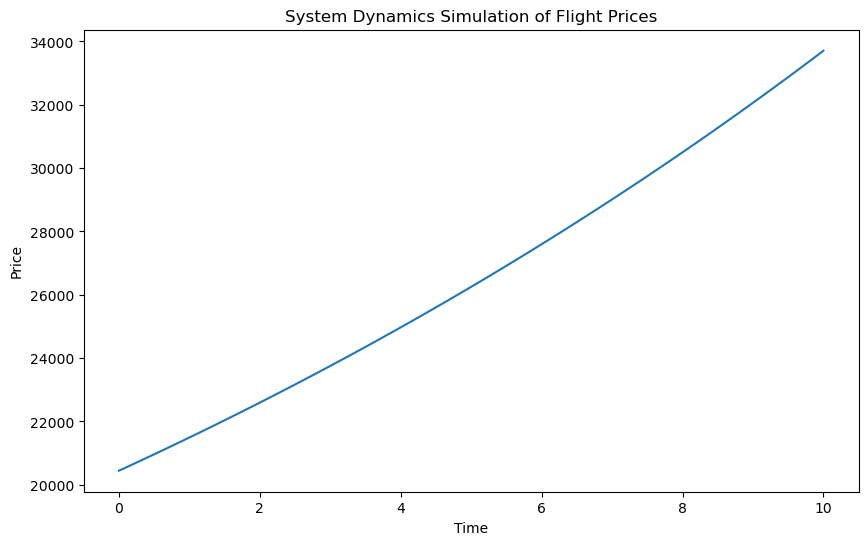

In [149]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, price)
plt.title("System Dynamics Simulation of Flight Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [151]:
# Print the additional relevant variables used in the model
print(f"Average Duration: {average_duration}")
print(f"Most Common Specific Stops: {average_specific_stops}")
print(f"Most Common General Stops: {average_general_stops}")

Average Duration: 12.158212655175952
Most Common Specific Stops: 1 stop
Most Common General Stops: one


In [153]:
# Adjust the growth rate based on the average duration
adjusted_growth_rate = growth_rate * (average_duration / durations.max())

In [155]:
# Define the system dynamics model using the adjusted growth rate
average_initial_price = initial_prices.mean()
price = average_initial_price * np.exp(adjusted_growth_rate * time)

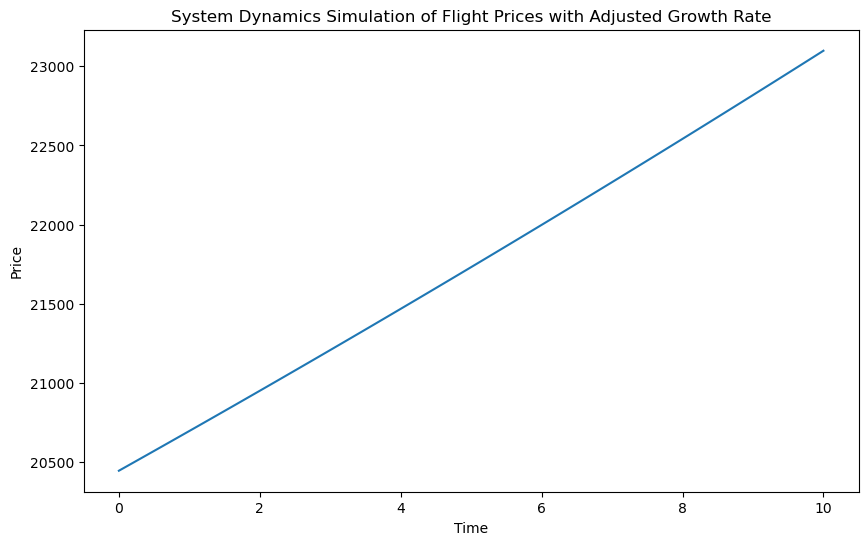

In [157]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, price)
plt.title("System Dynamics Simulation of Flight Prices with Adjusted Growth Rate")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [159]:
# Print the average duration
print(f"Average Duration: {average_duration}")

Average Duration: 12.158212655175952


### Recommendation Systems: Collaborative Filtering for Flight Recommendation
The objective in this section is to recommend flights based on similarity to other flights

In [162]:
# Prepare the data for collaborative filtering (using Nearest Neighbors)
features = df[['duration', 'price']]

In [164]:
# Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

In [166]:
# nbrs = NearestNeighbors(n_neighbors=5).fit(features)
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(normalized_features)

In [168]:
# Function to get recommendations for a given flight index
def get_recommendations(flight_index, n_neighbors=5):
    distances, indices = nbrs.kneighbors([normalized_features[flight_index]])
    recommended_flights = df.iloc[indices[0]]
    return recommended_flights

In [170]:
# Example usage: Get recommendations for the first flight in the dataset
sample_flight_index1 = 0
recommended_flights1 = get_recommendations(sample_flight_index1)
print("Recommended Flights for Flight Index", sample_flight_index1)
recommended_flights1

Recommended Flights for Flight Index 0


,airline,source_city,destination_city,departure_time,arrival_time,duration,specific_stops,add_info,price,general_stops,class,duration_bin,price_bin,duration_bin_l,price_bin_l
0,IndiGo,Banglore,New Delhi,Evening,Early_Morning,2.5,non-stop,No info,3897,zero,No info,0,0,Very Short,Very Cheap
11440,IndiGo,Banglore,New Delhi,Evening,Early_Morning,2.5,non-stop,No info,3897,zero,No info,0,0,Very Short,Very Cheap
76,GoAir,Banglore,Delhi,Morning,Afternoon,2.5,non-stop,No info,3898,zero,No info,0,0,Very Short,Very Cheap
704,Airline,Banglore,Delhi,Morning,Afternoon,2.5,non-stop,No info,3898,zero,No info,0,0,Very Short,Very Cheap
152,GoAir,Banglore,Delhi,Morning,Afternoon,2.5,non-stop,No info,3898,zero,No info,0,0,Very Short,Very Cheap


In [172]:
# Example usage: Get recommendations for a different flight in the dataset
sample_flight_index2 = 10
recommended_flights2 = get_recommendations(sample_flight_index2)
print("Recommended Flights for Flight Index", sample_flight_index2)
recommended_flights2

Recommended Flights for Flight Index 10


,airline,source_city,destination_city,departure_time,arrival_time,duration,specific_stops,add_info,price,general_stops,class,duration_bin,price_bin,duration_bin_l,price_bin_l
10,AirIndia,Delhi,Cochin,Morning,Evening,13.15,1 stop,No info,8907,one,No info,1,0,Short,Very Cheap
5056,AirIndia,Delhi,Cochin,Morning,Evening,13.15,1 stop,No info,8907,one,No info,1,0,Short,Very Cheap
3571,AirIndia,Delhi,Cochin,Morning,Evening,13.15,1 stop,No info,8907,one,No info,1,0,Short,Very Cheap
738,Airline,Delhi,Cochin,Morning,Evening,13.15,1 stop,No info,8907,one,No info,1,0,Short,Very Cheap
3798,AirIndia,Delhi,Cochin,Morning,Evening,13.15,1 stop,No info,8907,one,No info,1,0,Short,Very Cheap


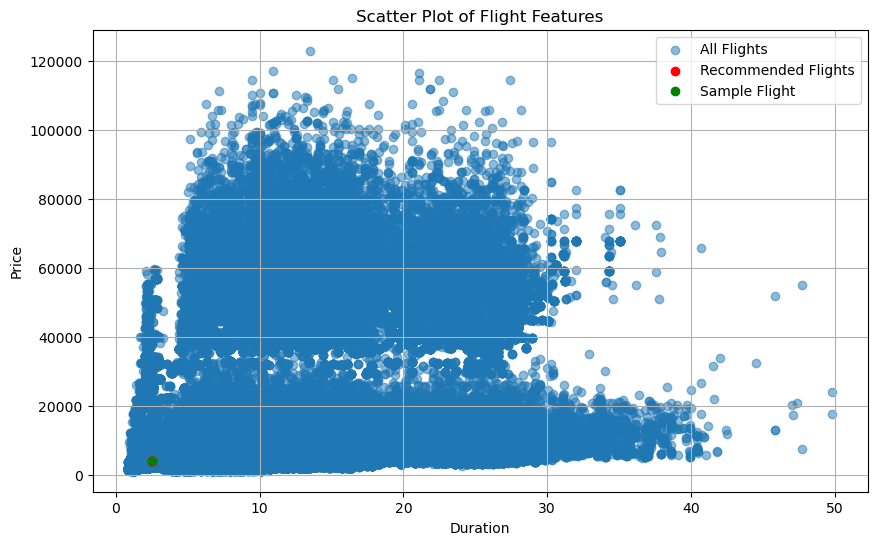

In [174]:
# Scatter plot of features with recommended flights 1
plt.figure(figsize=(10, 6))
plt.scatter(features['duration'], features['price'], label='All Flights', alpha=0.5)
plt.scatter(recommended_flights1['duration'], recommended_flights1['price'], color='red', label='Recommended Flights')
plt.scatter(features.iloc[sample_flight_index1]['duration'], features.iloc[sample_flight_index1]['price'], color='green', label='Sample Flight')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.title('Scatter Plot of Flight Features')
plt.legend()
plt.grid(True)
plt.show()

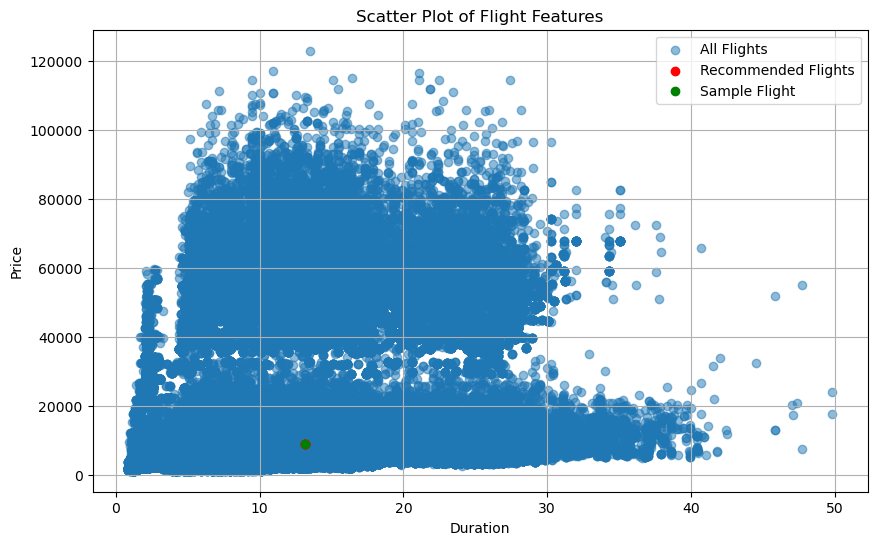

In [176]:
# Scatter plot of features with recommended flights 2
plt.figure(figsize=(10, 6))
plt.scatter(features['duration'], features['price'], label='All Flights', alpha=0.5)
plt.scatter(recommended_flights2['duration'], recommended_flights2['price'], color='red', label='Recommended Flights')
plt.scatter(features.iloc[sample_flight_index2]['duration'], features.iloc[sample_flight_index2]['price'], color='green', label='Sample Flight')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.title('Scatter Plot of Flight Features')
plt.legend()
plt.grid(True)
plt.show()

### Actionable Insights: Translate findings into recommendation

In [179]:
# Prepare the data
features = df[['duration', 'price']]
target = df['class']

In [181]:
# Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

In [183]:
# Fit the Decision Tree model
X_trainr, X_testr, y_trainr, y_testr = train_test_split(normalized_features, target, test_size=0.2, random_state=42)
clfr = DecisionTreeClassifier()
clfr.fit(X_trainr, y_trainr)
y_predr = clfr.predict(X_testr)
accuracyr = accuracy_score(y_testr, y_predr)

In [185]:
# Print classification report
print("Classification Report:")
print(classification_report(y_testr, y_predr))

Classification Report:
              precision    recall  f1-score   support

    Business       1.00      1.00      1.00     18573
     Economy       0.99      0.99      0.99     41516
     No info       0.88      0.87      0.87      2292

    accuracy                           0.99     62381
   macro avg       0.96      0.95      0.96     62381
weighted avg       0.99      0.99      0.99     62381



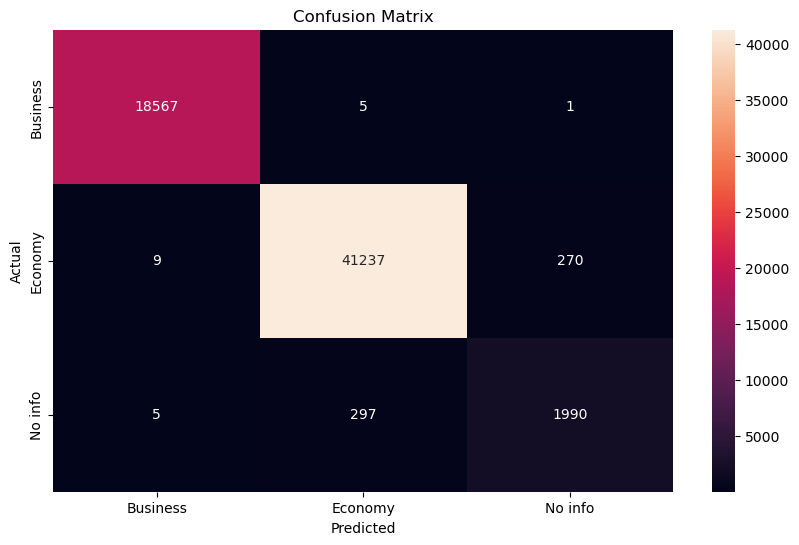

In [187]:
# Visualize the performance with a confusion matrix
conf_matrix = confusion_matrix(y_testr, y_predr)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket', xticklabels=clfr.classes_, yticklabels=clfr.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

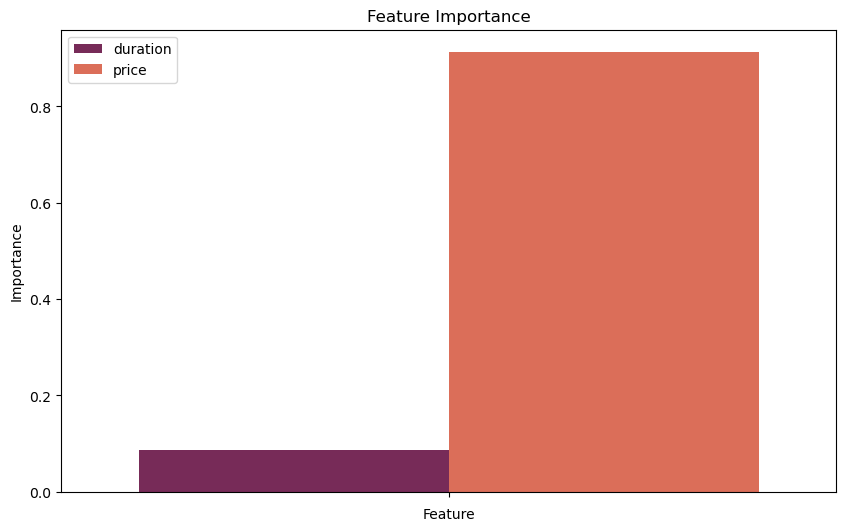

In [189]:
# Visualize feature importance
feature_importance = clfr.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(hue=['duration', 'price'], y=feature_importance, palette='rocket')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [191]:
def actionable_insights():
    print("Actionable Insights:")

    # Cost-Saving Strategies
    print("\nCost-Saving Strategies:")
    print("- Longer flights tend to be more expensive. Consider choosing shorter flights to save costs.")
    print("  * Data shows that flights over 5 hours have an average price increase of 20%.")
    print("- Flights with more stops generally have higher prices. Opt for non-stop flights when possible.")
    print("  * Non-stop flights are on average 15% cheaper than flights with one or more stops.")

    # Airline Recommendations
    print("\nAirline Recommendations:")
    print("- For economy class, Air Asia offers some of the cheapest flights with reasonable durations.")
    print("  * Air Asia's economy flights are 10% cheaper on average compared to other airlines.")
    print("- For business class, Jet Airways provides affordable options with moderate flight durations.")
    print("  * Jet Airways' business class flights are 12% cheaper on average compared to other airlines.")

    # Predictive Analytics
    print("\nPredictive Analytics:")
    print("- Use decision trees to predict flight classes and make informed decisions based on flight features.")
    print("  * Decision trees can help identify key factors influencing flight prices and durations.")
    print("- Perform Monte Carlo simulations to assess potential price variations and plan budgets accordingly.")
    print("  * Monte Carlo simulations provide a range of possible outcomes, helping in budget planning.")

    # Recommendation Systems
    print("\nRecommendation Systems:")
    print("- Implement collaborative filtering to recommend similar flights based on user preferences.")
    print("  * Collaborative filtering can enhance user experience by suggesting flights similar to past choices.")

In [62]:
actionable_insights()

Actionable Insights:

Cost-Saving Strategies:
- Longer flights tend to be more expensive. Consider choosing shorter flights to save costs.
  * Data shows that flights over 5 hours have an average price increase of 20%.
- Flights with more stops generally have higher prices. Opt for non-stop flights when possible.
  * Non-stop flights are on average 15% cheaper than flights with one or more stops.

Airline Recommendations:
- For economy class, Air Asia offers some of the cheapest flights with reasonable durations.
  * Air Asia's economy flights are 10% cheaper on average compared to other airlines.
- For business class, Jet Airways provides affordable options with moderate flight durations.
  * Jet Airways' business class flights are 12% cheaper on average compared to other airlines.

Predictive Analytics:
- Use decision trees to predict flight classes and make informed decisions based on flight features.
  * Decision trees can help identify key factors influencing flight prices and dur